In [1]:
import os
import sys
import pickle
import random
from pathlib import Path
from IPython.display import display


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import catboost as cab


sys.path.append("../../../")
from kagglib.tabular import (
    AbstractBaseBlock,
    IdentityBlock,
    WrapperBlock,
    LabelEncodingBlock,
    CountEncodingBlock,
    AggBlock,
    run_blocks,
)


pd.set_option('display.max_columns', 300)

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
class Config:
    exp = "exp_ensemble006"

    input_path = Path("../input")
    output_path = Path("../output")

    exp_path = output_path / exp
    exp_model_path = exp_path / "model"
    exp_pred_path = exp_path / "pred"

    for _path in [exp_path, exp_model_path, exp_pred_path]:
        if not _path.exists():
            _path.mkdir(parents=True)

    seed = 42
    n_splits = 5

cfg = Config

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
anime_df = pd.read_csv(cfg.input_path / "anime.csv")
train_df = pd.read_csv(cfg.input_path / "train.csv")
test_df = pd.read_csv(cfg.input_path / "test.csv")
sample_submission_df = pd.read_csv(cfg.input_path / "sample_submission.csv")

In [5]:
anime_df

,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch
0,000ba7f7e34e107e7544,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",宇宙兄弟,TV,99,"Apr 1, 2012 to Mar 22, 2014","Aniplex, Dentsu, YTV, Trinity Sound",Sentai Filmworks,A-1 Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,150428,16552,37234,13009,6948,76685
1,00427279d72064e7fb69,"Adventure, Slice of Life, Mystery, Historical,...",蟲師,TV,26,"Oct 23, 2005 to Jun 19, 2006","Avex Entertainment, Marvelous, SKY Perfect Wel...",Funimation,Artland,Manga,25 min. per ep.,PG-13 - Teens 13 or older,620736,55482,235371,42786,20017,267080
2,00444b67aaabdf740a68,"Adventure, Slice of Life, Mystery, Historical,...",蟲師 続章,TV,10,"Apr 5, 2014 to Jun 21, 2014","Aniplex, Kodansha, Delfi Sound",Aniplex of America,Artland,Manga,24 min. per ep.,PG-13 - Teens 13 or older,226522,12585,113559,6095,2606,91677
3,00839a3507ab168abe75,"Comedy, Ecchi, Fantasy, School",星刻の竜騎士,TV,12,"Apr 5, 2014 to Jun 21, 2014","Media Factory, AT-X, Sony Music Communications...",Funimation,C-Station,Light novel,24 min. per ep.,R+ - Mild Nudity,170220,8723,118202,3753,8034,31508
4,0192331235e110fe4f76,"Comedy, Harem, Romance, Sci-Fi, Shounen, Space",天地無用！,TV,26,"Apr 2, 1995 to Sep 24, 1995","TV Tokyo, Pioneer LDC","Funimation, Geneon Entertainment USA",AIC,Original,23 min. per ep.,PG-13 - Teens 13 or older,62599,2565,39890,2093,1986,16065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ff73475b68001c5e533d,"Adventure, Romance, Mecha, Military, Sci-Fi, H...",BLUE GENDER,TV,26,"Oct 8, 1999 to Mar 31, 2000","Youmex, Toshiba EMI",Funimation,AIC,Original,23 min. per ep.,R+ - Mild Nudity,65360,2738,31583,2534,3195,25310
1996,ff8611bae4e43862381f,"Ecchi, Romance, School",フォトカノ,TV,13,"Apr 5, 2013 to Jun 28, 2013","TBS, Enterbrain, BS-TBS, RAY",Sentai Filmworks,Madhouse,Visual novel,23 min. per ep.,PG-13 - Teens 13 or older,93558,6242,45399,3415,8680,29822
1997,ffa143ffd4abec9d2707,"Action, Fantasy, Military, Sci-Fi",GOD EATER,TV,13,"Jul 12, 2015 to Mar 26, 2016","Bandai Visual, Lantis, Anime Consortium Japan",Aniplex of America,ufotable,Game,23 min. per ep.,R - 17+ (violence & profanity),426616,35000,242285,16731,31573,101027
1998,ffb4819df40db39facfa,"Action, Adventure, Fantasy, School, Sci-Fi",鋼殻のレギオス,TV,24,"Jan 11, 2009 to Jun 21, 2009",AMG MUSIC,Funimation,Zexcs,Light novel,24 min. per ep.,R - 17+ (violence & profanity),178908,9139,118689,5611,6544,38925


In [6]:
train_df

,user_id,anime_id,score
0,0008e10fb39e55447333,0669cc0219d468761195,2
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1
3,0008e10fb39e55447333,2290175205d55e81b197,8
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9
...,...,...,...
136396,ffa6ff8006f8630f3d11,e9ba5ca32ea7e22e0a55,6
136397,ffa6ff8006f8630f3d11,ea2be994d7e36d2a720a,7
136398,ffa6ff8006f8630f3d11,ee3804a55e2b4ad58aad,7
136399,ffa6ff8006f8630f3d11,fc143f3fa9979ab1c230,9


In [7]:
dup_user_id = set(train_df["user_id"]) & set(test_df["user_id"])
dup_anime_id = set(train_df["anime_id"]) & set(test_df["anime_id"])
train_df["is_seen"] = 0
test_df["is_seen"] = 0

# seen
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
seen_train_idx = (train_df["user_id"].isin(dup_user_id)) & (train_df["anime_id"].isin(dup_anime_id))
seen_test_idx = (test_df["user_id"].isin(dup_user_id)) & (test_df["anime_id"].isin(dup_anime_id))
train_df.loc[seen_train_idx, "is_seen"] = 1
test_df.loc[seen_test_idx, "is_seen"] = 1

seen_train_df = train_df[train_df["is_seen"] == 1].copy().reset_index(drop=True)
seen_train_df["seen_fold"] = -1
for i_fold, (_, valid_idx) in enumerate(skf.split(seen_train_df, seen_train_df["score"])):
    seen_train_df.loc[valid_idx, "seen_fold"] = i_fold


# unseen
sgkf = StratifiedGroupKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
unseen_train_idx = (~train_df["user_id"].isin(dup_user_id)) | (~train_df["anime_id"].isin(dup_anime_id))
unseen_test_idx = (~test_df["user_id"].isin(dup_user_id)) | (~test_df["anime_id"].isin(dup_anime_id))
train_df.loc[unseen_train_idx, "is_seen"] = 0
test_df.loc[unseen_test_idx, "is_seen"] = 0

train_df["unseen_fold"] = -1
for i_fold, (_, valid_idx) in enumerate(sgkf.split(train_df, train_df["score"], train_df["user_id"])):
    train_df.loc[valid_idx, "unseen_fold"] = i_fold



train_df = pd.merge(train_df, seen_train_df[["user_id", "anime_id", "seen_fold"]], on=["user_id", "anime_id"], how="left")

In [12]:
import math

c_seen = 0.7726469288555016
c_unseen = 0.22735307114449846

def cv_score(seen, unseen):
    score = math.sqrt(c_seen * seen**2 + c_unseen * unseen**2)
    return score

# cv = cv_score(seen_score, unseen_score)
# print(f"CV: {cv:.5f}")

# Inference

## Matrix Factorization

In [67]:
from surprise import Dataset, Reader, SVD, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate

_train_df = train_df[train_df["is_seen"]==1].copy().reset_index(drop=True)
_test_df = test_df[test_df["is_seen"]==1].copy().reset_index(drop=True)
_test_df['score'] = np.nan

# _train_df = train_df.copy()
# _test_df = test_df.copy()
# _test_df['score'] = np.nan

seen_mf_oof = np.zeros(len(_train_df))
seen_mf_test_pred = np.zeros(len(_test_df))


for i_fold in range(cfg.n_splits):
    train_idx = _train_df[_train_df["seen_fold"]!=i_fold].index
    valid_idx = _train_df[_train_df["seen_fold"]==i_fold].index

    X_train = _train_df.iloc[train_idx].copy().reset_index(drop=True)
    X_valid = _train_df.iloc[valid_idx].copy().reset_index(drop=True)
    
    reader = Reader(rating_scale=(1, 10))
    train_data = Dataset.load_from_df(X_train[['user_id', 'anime_id', 'score']], reader)

    train_data = train_data.build_full_trainset()

    algo = SVDpp(
        random_state=cfg.seed,
        
        )
    _ = algo.fit(train_data)

    valid_data = Dataset.load_from_df(X_valid[['user_id', 'anime_id', 'score']], reader).build_full_trainset().build_testset()

    valid_pred = algo.test(valid_data)
    valid_pred = [pred.est for pred in valid_pred]
    seen_mf_oof[valid_idx] = valid_pred
    
    test_data = Dataset.load_from_df(_test_df[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
    test_pred = algo.test(test_data)
    test_pred = [pred.est for pred in test_pred]
    seen_mf_test_pred += np.array(test_pred) / cfg.n_splits

    print(f"Fold {i_fold + 1} RMSE: {mean_squared_error(X_valid['score'], valid_pred, squared=False):.4f}")

print(f"Overall RMSE: {mean_squared_error(_train_df['score'], seen_mf_oof, squared=False):.4f}")

Fold 1 RMSE: 1.1891
Fold 2 RMSE: 1.1919
Fold 3 RMSE: 1.1897
Fold 4 RMSE: 1.1905
Fold 5 RMSE: 1.1873
Overall RMSE: 1.1897


In [76]:
from surprise import Dataset, Reader, SVD, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate

_train_df = train_df[train_df["is_seen"]==1].copy().reset_index(drop=True)
_test_df = test_df[test_df["is_seen"]==1].copy().reset_index(drop=True)
_test_df['score'] = np.nan

knn_seen_mf_oof = np.zeros(len(_train_df))
knn_seen_mf_test_pred = np.zeros(len(_test_df))


for i_fold in range(cfg.n_splits):
    train_idx = _train_df[_train_df["seen_fold"]!=i_fold].index
    valid_idx = _train_df[_train_df["seen_fold"]==i_fold].index

    X_train = _train_df.iloc[train_idx].copy().reset_index(drop=True)
    X_valid = _train_df.iloc[valid_idx].copy().reset_index(drop=True)
    
    reader = Reader(rating_scale=(1, 10))
    train_data = Dataset.load_from_df(X_train[['user_id', 'anime_id', 'score']], reader)

    train_data = train_data.build_full_trainset()

    algo = KNNBaseline(
        random_state=cfg.seed,
        
        )
    _ = algo.fit(train_data)

    valid_data = Dataset.load_from_df(X_valid[['user_id', 'anime_id', 'score']], reader).build_full_trainset().build_testset()

    valid_pred = algo.test(valid_data)
    valid_pred = [pred.est for pred in valid_pred]
    knn_seen_mf_oof[valid_idx] = valid_pred
    
    test_data = Dataset.load_from_df(_test_df[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
    test_pred = algo.test(test_data)
    test_pred = [pred.est for pred in test_pred]
    knn_seen_mf_test_pred += np.array(test_pred) / cfg.n_splits

    print(f"Fold {i_fold + 1} RMSE: {mean_squared_error(X_valid['score'], valid_pred, squared=False):.4f}")

print(f"Overall RMSE: {mean_squared_error(_train_df['score'], knn_seen_mf_oof, squared=False):.4f}")

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 1 RMSE: 1.1886
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 2 RMSE: 1.1925
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 3 RMSE: 1.1909
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 4 RMSE: 1.1962
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 5 RMSE: 1.1873
Overall RMSE: 1.1911


In [68]:
from surprise import Dataset, Reader, SVD, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate

_train_df = train_df.copy()
_test_df = test_df.copy()
_test_df['score'] = np.nan

unseen_mf_oof = np.zeros(len(_train_df))
unseen_mf_test_pred = np.zeros(len(_test_df))


for i_fold in range(cfg.n_splits):
    train_idx = _train_df[_train_df["unseen_fold"]!=i_fold].index
    valid_idx = _train_df[_train_df["unseen_fold"]==i_fold].index

    X_train = _train_df.iloc[train_idx].copy().reset_index(drop=True)
    X_valid = _train_df.iloc[valid_idx].copy().reset_index(drop=True)
    
    reader = Reader(rating_scale=(1, 10))
    # Create the dataset to be used for building the filter
    train_data = Dataset.load_from_df(X_train[['user_id', 'anime_id', 'score']], reader)

    # Retrieve the trainset.
    train_data = train_data.build_full_trainset()

    # Build an algorithm, and train it.
    algo = SVDpp(
        random_state=cfg.seed,
        
        )
    _ = algo.fit(train_data)

    # Convert the test dataset to the surprise format
    valid_data = Dataset.load_from_df(X_valid[['user_id', 'anime_id', 'score']], reader).build_full_trainset().build_testset()

    # Predict ratngs for the testset
    valid_pred = algo.test(valid_data)
    valid_pred = [pred.est for pred in valid_pred]
    unseen_mf_oof[valid_idx] = valid_pred
    
    test_data = Dataset.load_from_df(_test_df[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
    test_pred = algo.test(test_data)
    test_pred = [pred.est for pred in test_pred]
    unseen_mf_test_pred += np.array(test_pred) / cfg.n_splits

    print(f"Fold {i_fold + 1} RMSE: {mean_squared_error(X_valid['score'], valid_pred, squared=False):.4f}")

print(f"Overall RMSE: {mean_squared_error(_train_df['score'], unseen_mf_oof, squared=False):.4f}")

Fold 1 RMSE: 1.4683
Fold 2 RMSE: 1.3983
Fold 3 RMSE: 1.4026
Fold 4 RMSE: 1.5030
Fold 5 RMSE: 1.4542
Overall RMSE: 1.4468


In [77]:
from surprise import Dataset, Reader, SVD, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate

# _train_df = train_df[train_df["is_knn_unseen"]==1].copy().reset_index(drop=True)

# _test_df = test_df[test_df["is_knn_unseen"]==1].copy().reset_index(drop=True)
# _test_df['score'] = np.nan

_train_df = train_df.copy()
_test_df = test_df.copy()
_test_df['score'] = np.nan

knn_unseen_mf_oof = np.zeros(len(_train_df))
knn_unseen_mf_test_pred = np.zeros(len(_test_df))


for i_fold in range(cfg.n_splits):
    train_idx = _train_df[_train_df["unseen_fold"]!=i_fold].index
    valid_idx = _train_df[_train_df["unseen_fold"]==i_fold].index

    X_train = _train_df.iloc[train_idx].copy().reset_index(drop=True)
    X_valid = _train_df.iloc[valid_idx].copy().reset_index(drop=True)
    
    reader = Reader(rating_scale=(1, 10))
    # Create the dataset to be used for building the filter
    train_data = Dataset.load_from_df(X_train[['user_id', 'anime_id', 'score']], reader)

    # Retrieve the trainset.
    train_data = train_data.build_full_trainset()

    # Build an algorithm, and train it.
    algo = KNNBaseline(
        random_state=cfg.seed,
        
        )
    _ = algo.fit(train_data)

    # Convert the test dataset to the surprise format
    valid_data = Dataset.load_from_df(X_valid[['user_id', 'anime_id', 'score']], reader).build_full_trainset().build_testset()

    # Predict ratngs for the testset
    valid_pred = algo.test(valid_data)
    valid_pred = [pred.est for pred in valid_pred]
    knn_unseen_mf_oof[valid_idx] = valid_pred
    
    test_data = Dataset.load_from_df(_test_df[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
    test_pred = algo.test(test_data)
    test_pred = [pred.est for pred in test_pred]
    knn_unseen_mf_test_pred += np.array(test_pred) / cfg.n_splits

    print(f"Fold {i_fold + 1} RMSE: {mean_squared_error(X_valid['score'], valid_pred, squared=False):.4f}")

print(f"Overall RMSE: {mean_squared_error(_train_df['score'], knn_unseen_mf_oof, squared=False):.4f}")

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 1 RMSE: 1.4619
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 2 RMSE: 1.3936
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 3 RMSE: 1.3972
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 4 RMSE: 1.4948
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Fold 5 RMSE: 1.4516
Overall RMSE: 1.4413


# Ensemble

In [25]:
# exp043 cab cv: 1.17675
seen_oof_exp043 = pickle.load(open(cfg.output_path / "exp043" / "pred" / "seen_oof.pkl", "rb")) # 1.11032
unseen_oof_exp043 = pickle.load(open(cfg.output_path / "exp043" / "pred" / "unseen_oof.pkl", "rb")) # 1.37674
test_pred_exp043 = pd.read_csv(cfg.output_path  / "sub_exp043_cab.csv")["score"].values

# exp053 lgb cv: 1.17964
seen_oof_exp053 = pickle.load(open(cfg.output_path / "exp053" / "pred" / "seen_oof.pkl", "rb")) # 1.11171
unseen_oof_exp053 = pickle.load(open(cfg.output_path / "exp053" / "pred" / "unseen_oof.pkl", "rb")) # 1.38581
test_pred_exp053 = pd.read_csv(cfg.output_path  / "sub_exp053.csv")["score"].values

# exp055 xgb
seen_oof_exp055 = pickle.load(open(cfg.output_path / "exp055" / "pred" / "seen_oof.pkl", "rb")) # 1.12081
unseen_oof_exp055 = pickle.load(open(cfg.output_path / "exp055" / "pred" / "unseen_oof.pkl", "rb")) # 1.38728
test_pred_exp055 = pd.read_csv(cfg.output_path  / "sub_exp055.csv")["score"].values

In [78]:
from scipy.optimize import minimize

def seen_rmse_score(weights):
    seen_oof = weights[0]*seen_oof_exp043 + weights[1]*seen_oof_exp053 + weights[2]*seen_oof_exp055 +  weights[3]*seen_mf_oof + weights[4]*knn_seen_mf_oof
    seen_oof = np.clip(seen_oof, 1, 10)
    return mean_squared_error(train_df[train_df["is_seen"]==1]['score'], seen_oof, squared=False)

seen_res = minimize(
    seen_rmse_score, 
    [0.2, 0.2, 0.2, 0.2, 0.2], 
    method='Nelder-Mead',
    )

seen_score = seen_res.fun
print(seen_res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.1000490291825489
             x: [ 4.992e-01  4.738e-01  4.182e-02  1.102e-01 -1.249e-01]
           nit: 370
          nfev: 597
 final_simplex: (array([[ 4.992e-01,  4.738e-01, ...,  1.102e-01,
                        -1.249e-01],
                       [ 4.993e-01,  4.737e-01, ...,  1.102e-01,
                        -1.249e-01],
                       ...,
                       [ 4.992e-01,  4.738e-01, ...,  1.102e-01,
                        -1.249e-01],
                       [ 4.993e-01,  4.738e-01, ...,  1.102e-01,
                        -1.249e-01]]), array([ 1.100e+00,  1.100e+00,  1.100e+00,  1.100e+00,
                        1.100e+00,  1.100e+00]))


In [79]:
def unseen_rmse_score(weights):
    unseen_oof = weights[0]*unseen_oof_exp043 + weights[1]*unseen_oof_exp053 + weights[2]*unseen_oof_exp055 + weights[3]*unseen_mf_oof + weights[4]*knn_unseen_mf_oof
    unseen_oof = np.clip(unseen_oof, 1, 10)
    return mean_squared_error(train_df['score'], unseen_oof, squared=False)

unseen_res = minimize(
    unseen_rmse_score,
    [0.2, 0.2, 0.2, 0.2, 0.2],
    method='Nelder-Mead',
    )
unseen_score = unseen_res.fun
print(unseen_res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3730065722800646
             x: [ 5.754e-01  2.204e-01  3.425e-02  5.314e-04  1.656e-01]
           nit: 305
          nfev: 500
 final_simplex: (array([[ 5.754e-01,  2.204e-01, ...,  5.314e-04,
                         1.656e-01],
                       [ 5.754e-01,  2.204e-01, ...,  5.603e-04,
                         1.656e-01],
                       ...,
                       [ 5.754e-01,  2.204e-01, ...,  5.588e-04,
                         1.656e-01],
                       [ 5.755e-01,  2.204e-01, ...,  5.832e-04,
                         1.656e-01]]), array([ 1.373e+00,  1.373e+00,  1.373e+00,  1.373e+00,
                        1.373e+00,  1.373e+00]))


In [80]:
cv = cv_score(seen_score, unseen_score)
print(f"CV: {cv:.5f}")

CV: 1.16772


In [85]:
seen_oof = seen_res.x[0]*seen_oof_exp043 + seen_res.x[1]*seen_oof_exp053 + seen_res.x[2]*seen_oof_exp055 + seen_res.x[3]*seen_mf_oof + seen_res.x[4]*knn_seen_mf_oof
seen_oof = np.clip(seen_oof, 1, 10)

unseen_oof = unseen_res.x[0]*unseen_oof_exp043 + unseen_res.x[1]*unseen_oof_exp053 + unseen_res.x[2]*unseen_oof_exp055 + unseen_res.x[3]*unseen_mf_oof + unseen_res.x[4]*knn_unseen_mf_oof
unseen_oof = np.clip(unseen_oof, 1, 10)

In [97]:
test_df["score"] = 0

seen_test_idx = test_df[test_df["is_seen"]==1].index
unseen_test_idx = test_df[test_df["is_seen"]==0].index

seen_test_pred = seen_res.x[0]*test_pred_exp043[seen_test_idx] + seen_res.x[1]*test_pred_exp053[seen_test_idx] + seen_res.x[2]*test_pred_exp055[seen_test_idx] + seen_res.x[3]*seen_mf_test_pred + seen_res.x[4]*knn_seen_mf_test_pred
seen_test_pred = np.clip(seen_test_pred, 1, 10)
test_df.loc[test_df["is_seen"]==1, "score"] = seen_test_pred

unseen_test_pred = unseen_res.x[0]*test_pred_exp043[unseen_test_idx] + unseen_res.x[1]*test_pred_exp053[unseen_test_idx] + unseen_res.x[2]*test_pred_exp055[unseen_test_idx] + unseen_res.x[3]*unseen_mf_test_pred[unseen_test_idx] + unseen_res.x[4]*knn_unseen_mf_test_pred[unseen_test_idx]
unseen_test_pred = np.clip(unseen_test_pred, 1, 10)
test_df.loc[test_df["is_seen"]==0, "score"] = unseen_test_pred

test_df[["score"]].to_csv(cfg.output_path / f"sub_{cfg.exp}.csv", index=False)

Text(0.5, 1.0, 'All users')

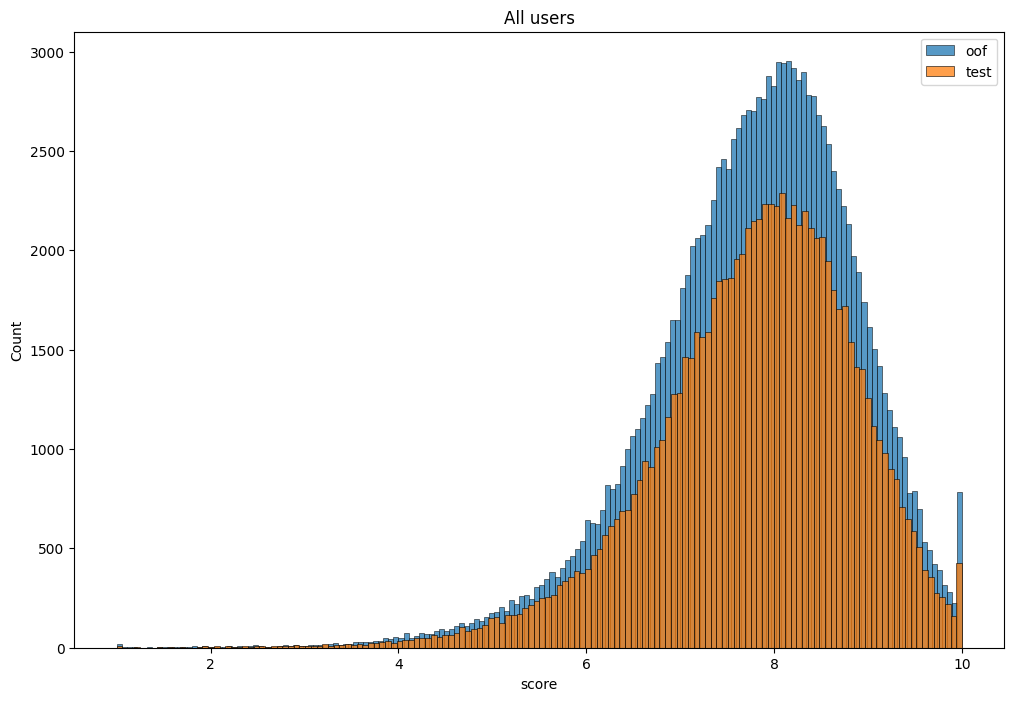

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=seen_oof, label="oof")
# sns.histplot(data=train_df["score"], label="target")
sns.histplot(data=test_df.iloc[seen_test_idx]["score"], label="test")
ax.legend()
ax.set_title("All users")

Text(0.5, 1.0, 'All users')

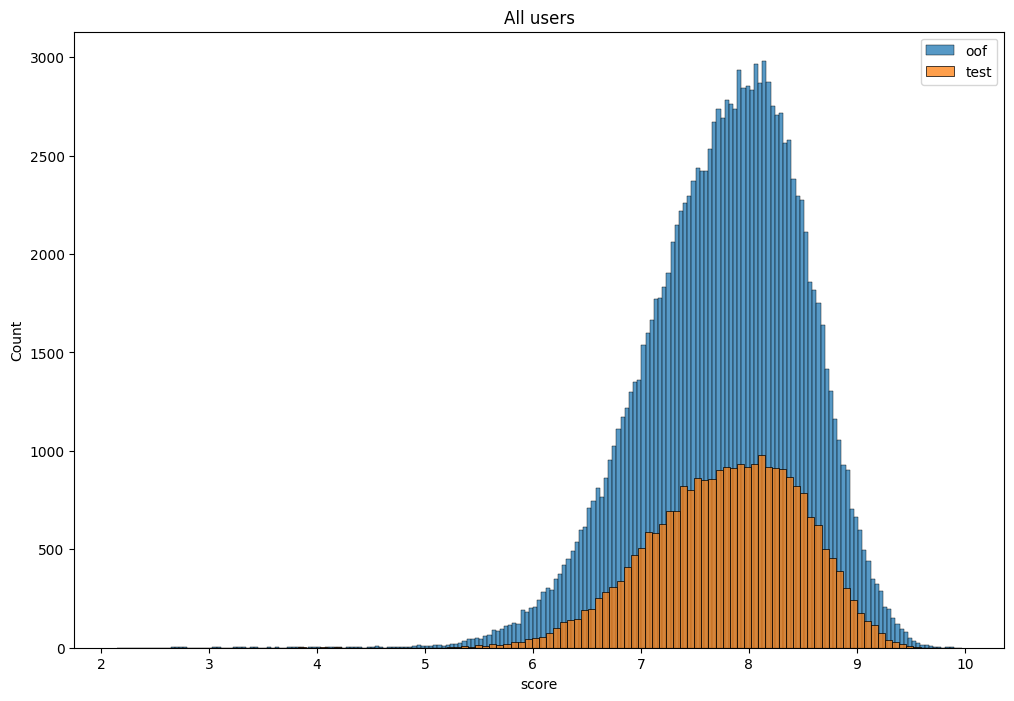

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=unseen_oof, label="oof")
# sns.histplot(data=train_df["score"], label="target")
sns.histplot(data=test_df[test_df["is_seen"]==0]["score"], label="test")
ax.legend()
ax.set_title("All users")